# 🌌 Photo-Z Challenge: Data Visualization & Exploration 🔭

Welcome to the data visualization step of the Photo-Z Challenge! Before feeding data into our Machine Learning models, it is crucial to understand what our dataset looks like. 

In this notebook, we will:
1. Set up our environment and configuration. ⚙️
2. Visualize global properties of our catalog (Redshift distributions and Color-Magnitude diagrams). 📊
3. Inspect the Spectral Energy Distributions (SED) of individual galaxies and Quasars (QSOs). 🌈

In [1]:
%%writefile config.yaml
experiment:
  group_name: "ANN_turtle"
  save_dir: "models/"

data:
  train_path: "data/training_set.h5"
  val_path: "data/validation_set.h5"
  batch_size: 1000
  target_col: "Z" 
  inputs:
    FilterJPAS: [
      'J0378', 'J0390', 'J0400', 'J0410', 'J0420', 'J0430', 'J0440', 'J0450',
      'J0460', 'J0470', 'J0480', 'J0490', 'J0500', 'J0510', 'J0520', 'J0530',
      'J0540', 'J0550', 'J0560', 'J0570', 'J0580', 'J0590', 'J0600', 'J0610',
      'J0620', 'J0630', 'J0640', 'J0650', 'J0660', 'J0670', 'J0680', 'J0690',
      'J0700', 'J0710', 'J0720', 'J0730', 'J0740', 'J0750', 'J0760', 'J0770',
      'J0780', 'J0790', 'J0800', 'J0810', 'J0820', 'J0830', 'J0840', 'J0850',
      'J0860', 'J0870', 'J0880', 'J0890', 'J0900', 'J0910'
    ]
    MAGNITUDES: [
      'MAG_NUV','MAG_FUV','MAG_G','MAG_R','MAG_i','MAG_Z',"MAG_J_2MASS",
      "MAG_H_2MASS","MAG_Ks_2MASS",'MAG_W1','MAG_W2','MAG_W3','MAG_W4', 'iSDSS'
    ]

  selected_features: ["FilterJPAS", "MAGNITUDES"] 
  
  features_to_normalize: ["MAGNITUDES"] 

model:
  type: "neural_net" # Options: "neural_net", "random_forest"
  
  # Neural network parameters
  hidden_layers: [512,512,512]
  dropout_rates: [0.3, 0.3] 
  output_size: 1
  
  # Random Forest parameters
  n_estimators: 500
  max_depth: 100

training:
  epochs: 100
  learning_rate: 0.001
  loss_type: "deltaz"

Overwriting config.yaml


## 🛠️ Environment Setup & Imports

First, let's configure our computational environment. We strictly limit the number of threads for our linear algebra libraries to ensure stable and reproducible performance across different machines. 💻 

We also set up our plotting style for maximum readability! 🎨

In [10]:
import os

import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker

# --- 2. GLOBAL PLOTTING STYLE SETTINGS ---
plt.style.use('dark_background')

plt.rcParams.update({
    'font.size': 30,
    'axes.labelsize': 24,
    'axes.titlesize': 26,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 30,
    'lines.linewidth': 5,
    'axes.grid': False,      
    'legend.loc': 'lower left' 
})

# Define standard colors for object types
COLOR_MAP = {
    'GALAXY_ID': 'green',
    'QSO': 'tab:red',
    'GALAXY_OOD1': 'yellow',
    'GALAXY_OOD2': 'gold',
    'GALAXY_OOD': 'yellow',
    'GALAXY': 'green'
}

def get_color(type_name):
    return COLOR_MAP.get(type_name, 'white')

def get_smart_limits(data, padding=0.05):
    """Calculates axis limits based on percentiles to cleanly filter out extreme outliers."""
    valid_data = data[np.isfinite(data)]
    if len(valid_data) == 0:
        return 0, 1
    
    low = np.percentile(valid_data, 1)
    high = np.percentile(valid_data, 99)
    
    span = high - low
    return low - span * padding, high + span * padding

## 📈 Dataset Diagnostics

Now, let's load our validation set and create some classic astronomical plots. We will look at:
* **Redshift Distribution**: How are the distances of our objects distributed? 📏
* **Color-Magnitude Diagrams**: These help us classify objects based on how bright they are in different photometric bands (Optical, UV, and IR). ✨


Reading file: ./data/validation_set.h5 ...
Generating diagnostic plots for screen display... 🖥️


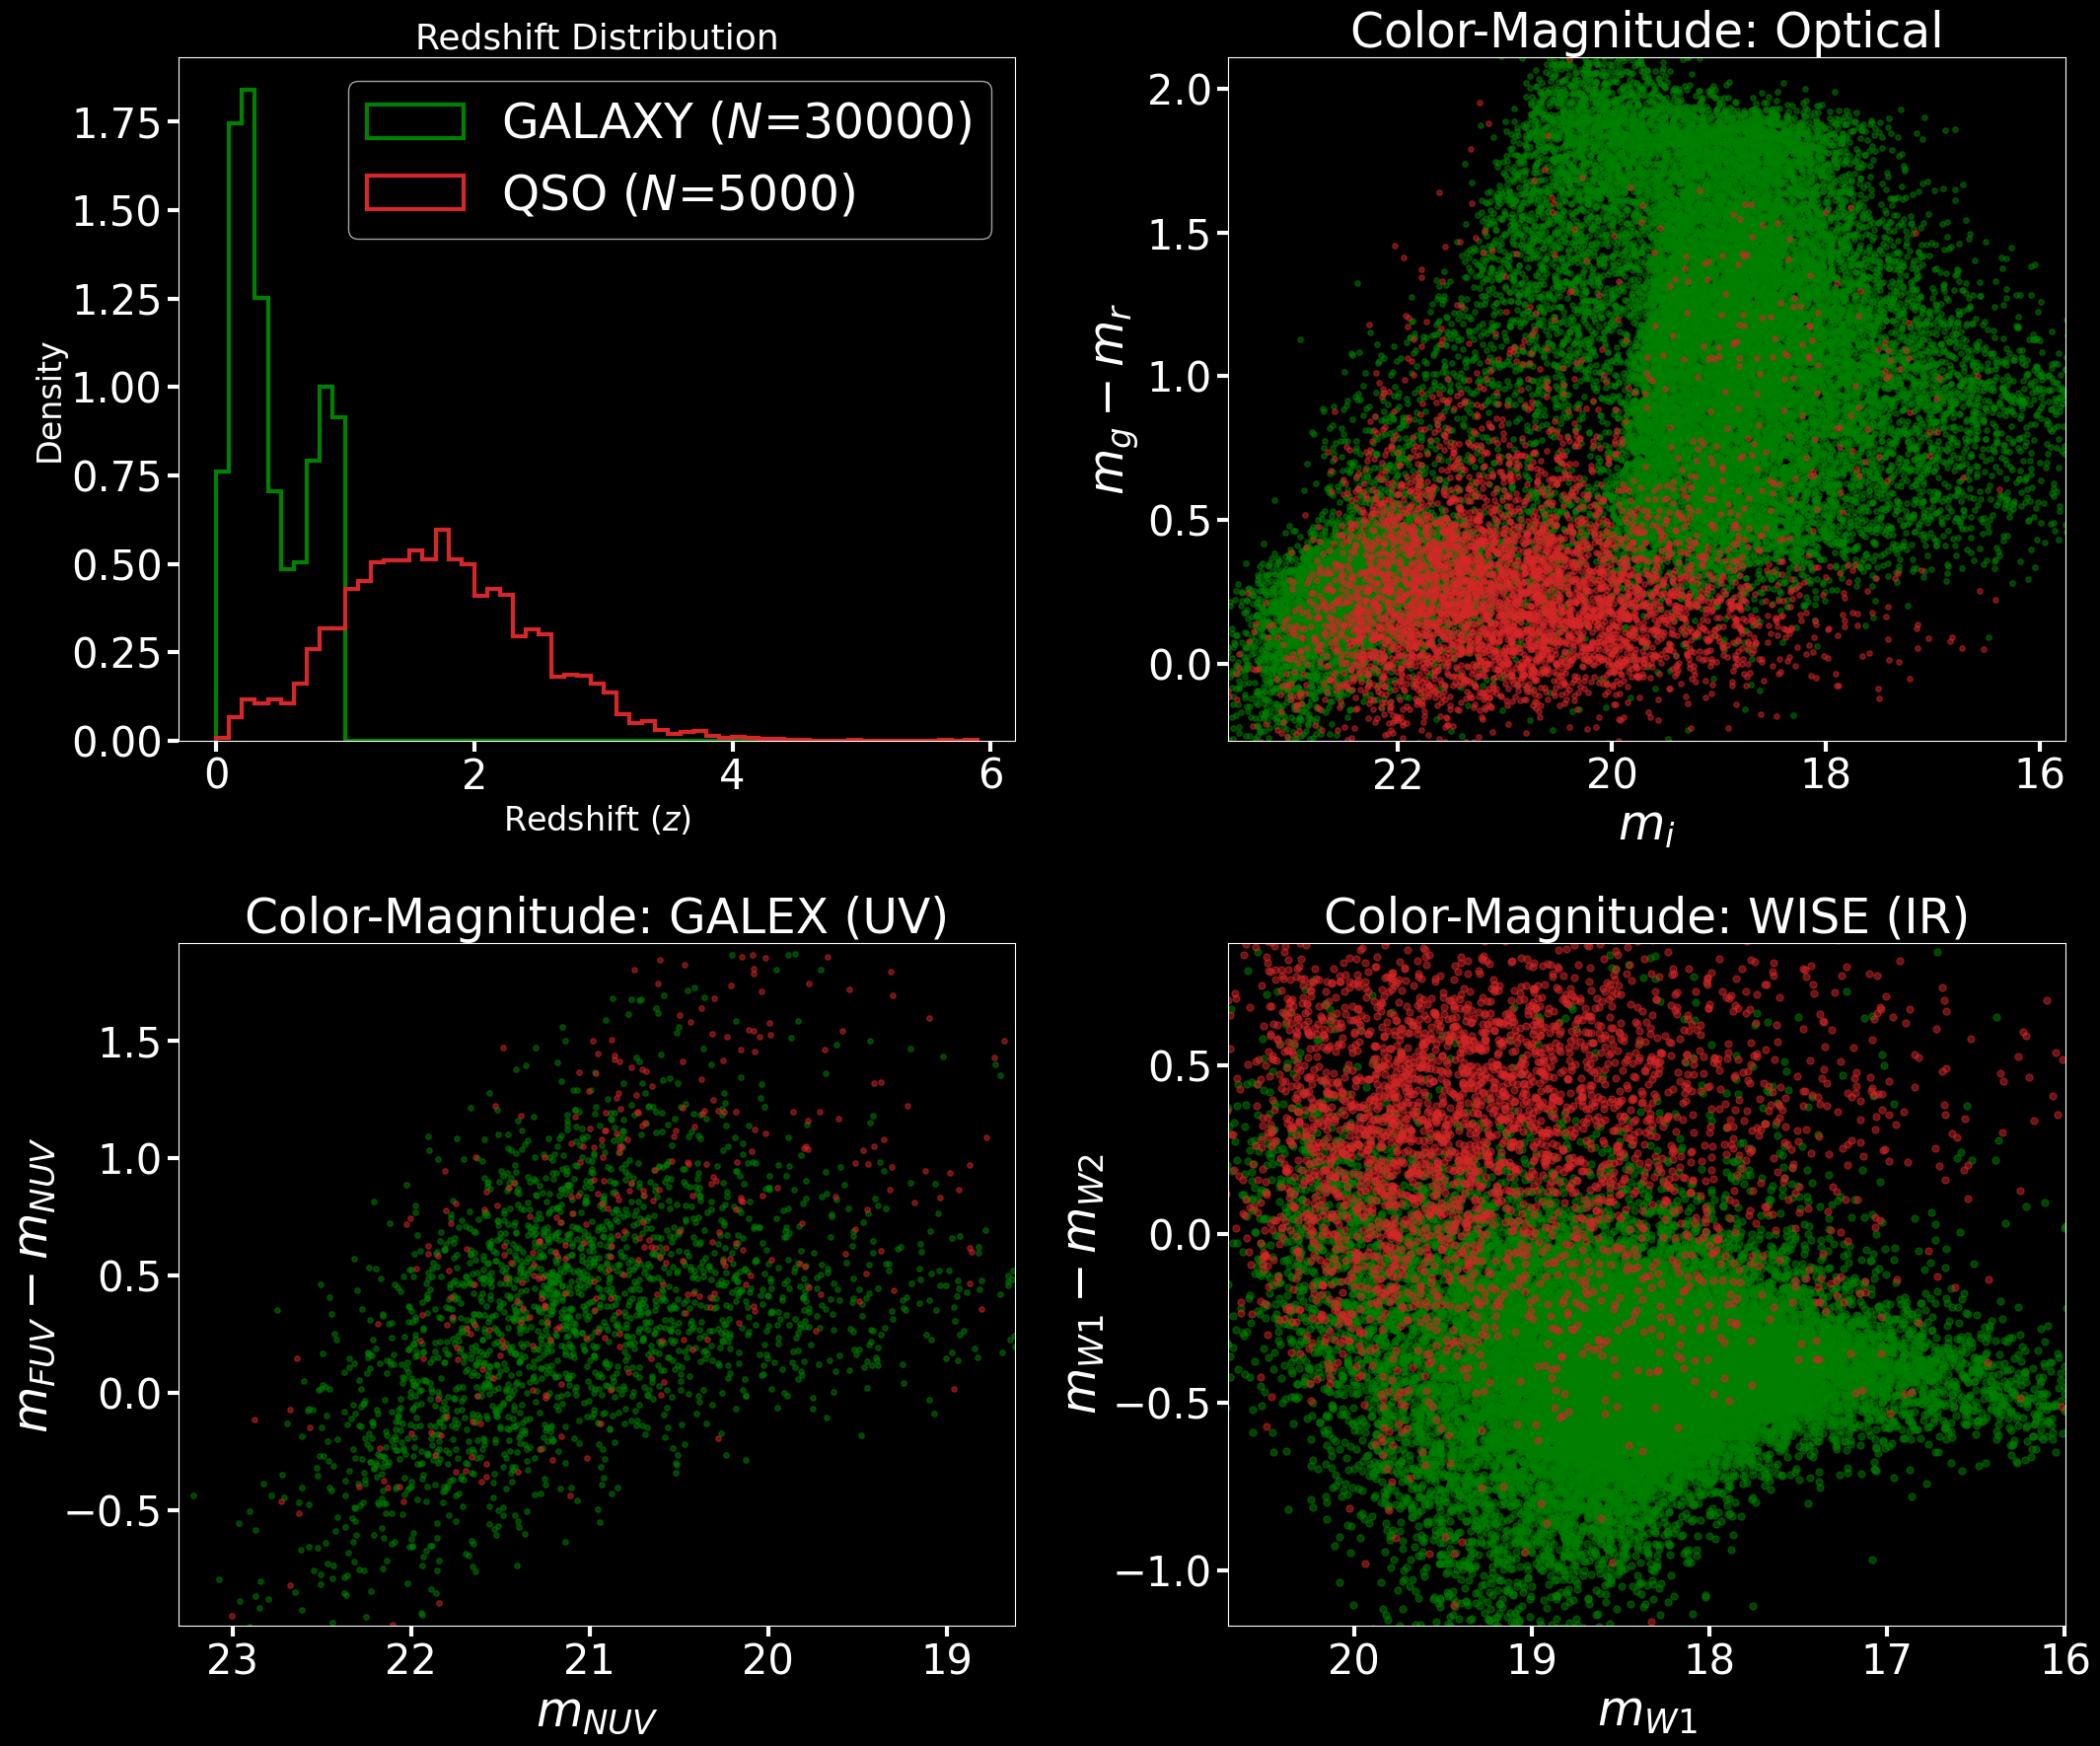

Diagnostics plots displayed successfully! 🎊


In [25]:
import os


def plot_dataset(file_path):
    print(f"Reading file: {file_path} ...")
    
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} not found.")
        return

    # Load the dataset
    with pd.HDFStore(file_path, 'r') as store:
        df = store['data']
    
    print("Generating diagnostic plots for screen display... 🖥️")

    fig, axs = plt.subplots(2, 2, figsize=(22, 20))
    unique_types = np.sort(df['TYPE'].unique())

    # --- PLOT 1: Z Distribution ---
    ax1 = axs[0, 0]
    if 'Z' in df.columns:
        z_data_all = df['Z'].dropna()
        bins = np.linspace(z_data_all.min(), z_data_all.max(), 60)

        for t in unique_types:
            subset = df[df['TYPE'] == t]
            data_z = subset['Z'].dropna()
            ax1.hist(data_z, bins=bins, density=True, 
                     histtype='step', lw=3,
                     label=f"{t} ($N$={len(data_z)})", 
                     color=get_color(t))
    
    ax1.set_xlabel(r'Redshift ($z$)')
    ax1.set_ylabel('Density')
    ax1.set_title('Redshift Distribution')
    ax1.legend(loc='upper right')
    ax1.tick_params(axis='both', labelsize=30, 
                        width=3, length=8)
    # --- PLOT 2: Color-Magnitude Diagram (Optical: i vs g-r) ---
    ax2 = axs[0, 1]
    if all(col in df.columns for col in ['MAG_G', 'MAG_R', 'MAG_i']):
        x_val = df['MAG_i']
        y_val = df['MAG_G'] - df['MAG_R']
        
        for t in unique_types:
            mask = df['TYPE'] == t
            ax2.scatter(x_val[mask], y_val[mask], s=15, alpha=0.5, 
                        label=t, color=get_color(t))
            
        ax2.set_xlabel(r'$m_i$',fontsize=35)
        ax2.set_ylabel(r'$m_g - m_r$',fontsize=35)
        ax2.set_title('Color-Magnitude: Optical',fontsize=35)
        
        xlims = get_smart_limits(x_val)
        ylims = get_smart_limits(y_val)
        ax2.set_ylim(ylims)
        ax2.set_xlim(xlims[1], xlims[0]) 
        ax2.tick_params(axis='both', labelsize=30, 
                        width=3, length=8)
    else:
        ax2.text(0.5, 0.5, "Missing Optical Columns", ha='center')

    # --- PLOT 3: Color-Magnitude Diagram (GALEX: NUV vs FUV-NUV) ---
    ax3 = axs[1, 0]
    if all(col in df.columns for col in ['MAG_FUV', 'MAG_NUV']):
        x_val = df['MAG_NUV']
        y_val = df['MAG_FUV'] - df['MAG_NUV']
        
        for t in unique_types:
            mask = df['TYPE'] == t
            ax3.scatter(x_val[mask], y_val[mask], s=15, alpha=0.5, 
                        label=t, color=get_color(t))
        
        ax3.set_xlabel(r'$m_{NUV}$',fontsize=35)
        ax3.set_ylabel(r'$m_{FUV} - m_{NUV}$',fontsize=35)
        ax3.set_title('Color-Magnitude: GALEX (UV)',fontsize=35)
        
        xlims = get_smart_limits(x_val)
        ylims = get_smart_limits(y_val)
        ax3.set_ylim(ylims)
        ax3.set_xlim(xlims[1], xlims[0])
        ax3.tick_params(axis='both', labelsize=30, 
                        width=3, length=8)
    else:
        ax3.text(0.5, 0.5, "Missing GALEX Columns", ha='center')

    # --- PLOT 4: Color-Magnitude Diagram (WISE: W1 vs W1-W2) ---
    ax4 = axs[1, 1]
    if all(col in df.columns for col in ['MAG_W1', 'MAG_W2']):
        x_val = df['MAG_W1']
        y_val = df['MAG_W1'] - df['MAG_W2']
        
        for t in unique_types:
            mask = df['TYPE'] == t
            ax4.scatter(x_val[mask], y_val[mask], s=25, alpha=0.5, 
                         label=t, color=get_color(t))
        
        ax4.set_xlabel(r'$m_{W1}$',fontsize=35)
        ax4.set_ylabel(r'$m_{W1} - m_{W2}$',fontsize=35)
        ax4.set_title('Color-Magnitude: WISE (IR)',fontsize=35)
        
        xlims = get_smart_limits(x_val)
        ylims = get_smart_limits(y_val)
        ax4.set_ylim(ylims)
        ax4.set_xlim(xlims[1], xlims[0])
        
        ax4.tick_params(axis='both', labelsize=30, 
                        width=3, length=8)

    else:
        ax4.text(0.5, 0.5, "Missing WISE Columns", ha='center')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show() # <--- Display inline instead of saving!
    print("Diagnostics plots displayed successfully! 🎊")

# Run it on the validation set
plot_dataset('./data/validation_set.h5')

## 🌈 Spectral Energy Distributions (SED)

Machine learning models predict the redshift by analyzing the SED of the objects. 
Let's select a few random Galaxies and QSOs from our training set and visualize both their narrow-band J-PAS spectra and their broad-band magnitudes! 🔭

We will map the photometric bands to their effective wavelengths and highlight important emission lines for context. Everything will be plotted directly in the notebook. 🌟

Plotting J-PAS Photo-spectra... 🌠


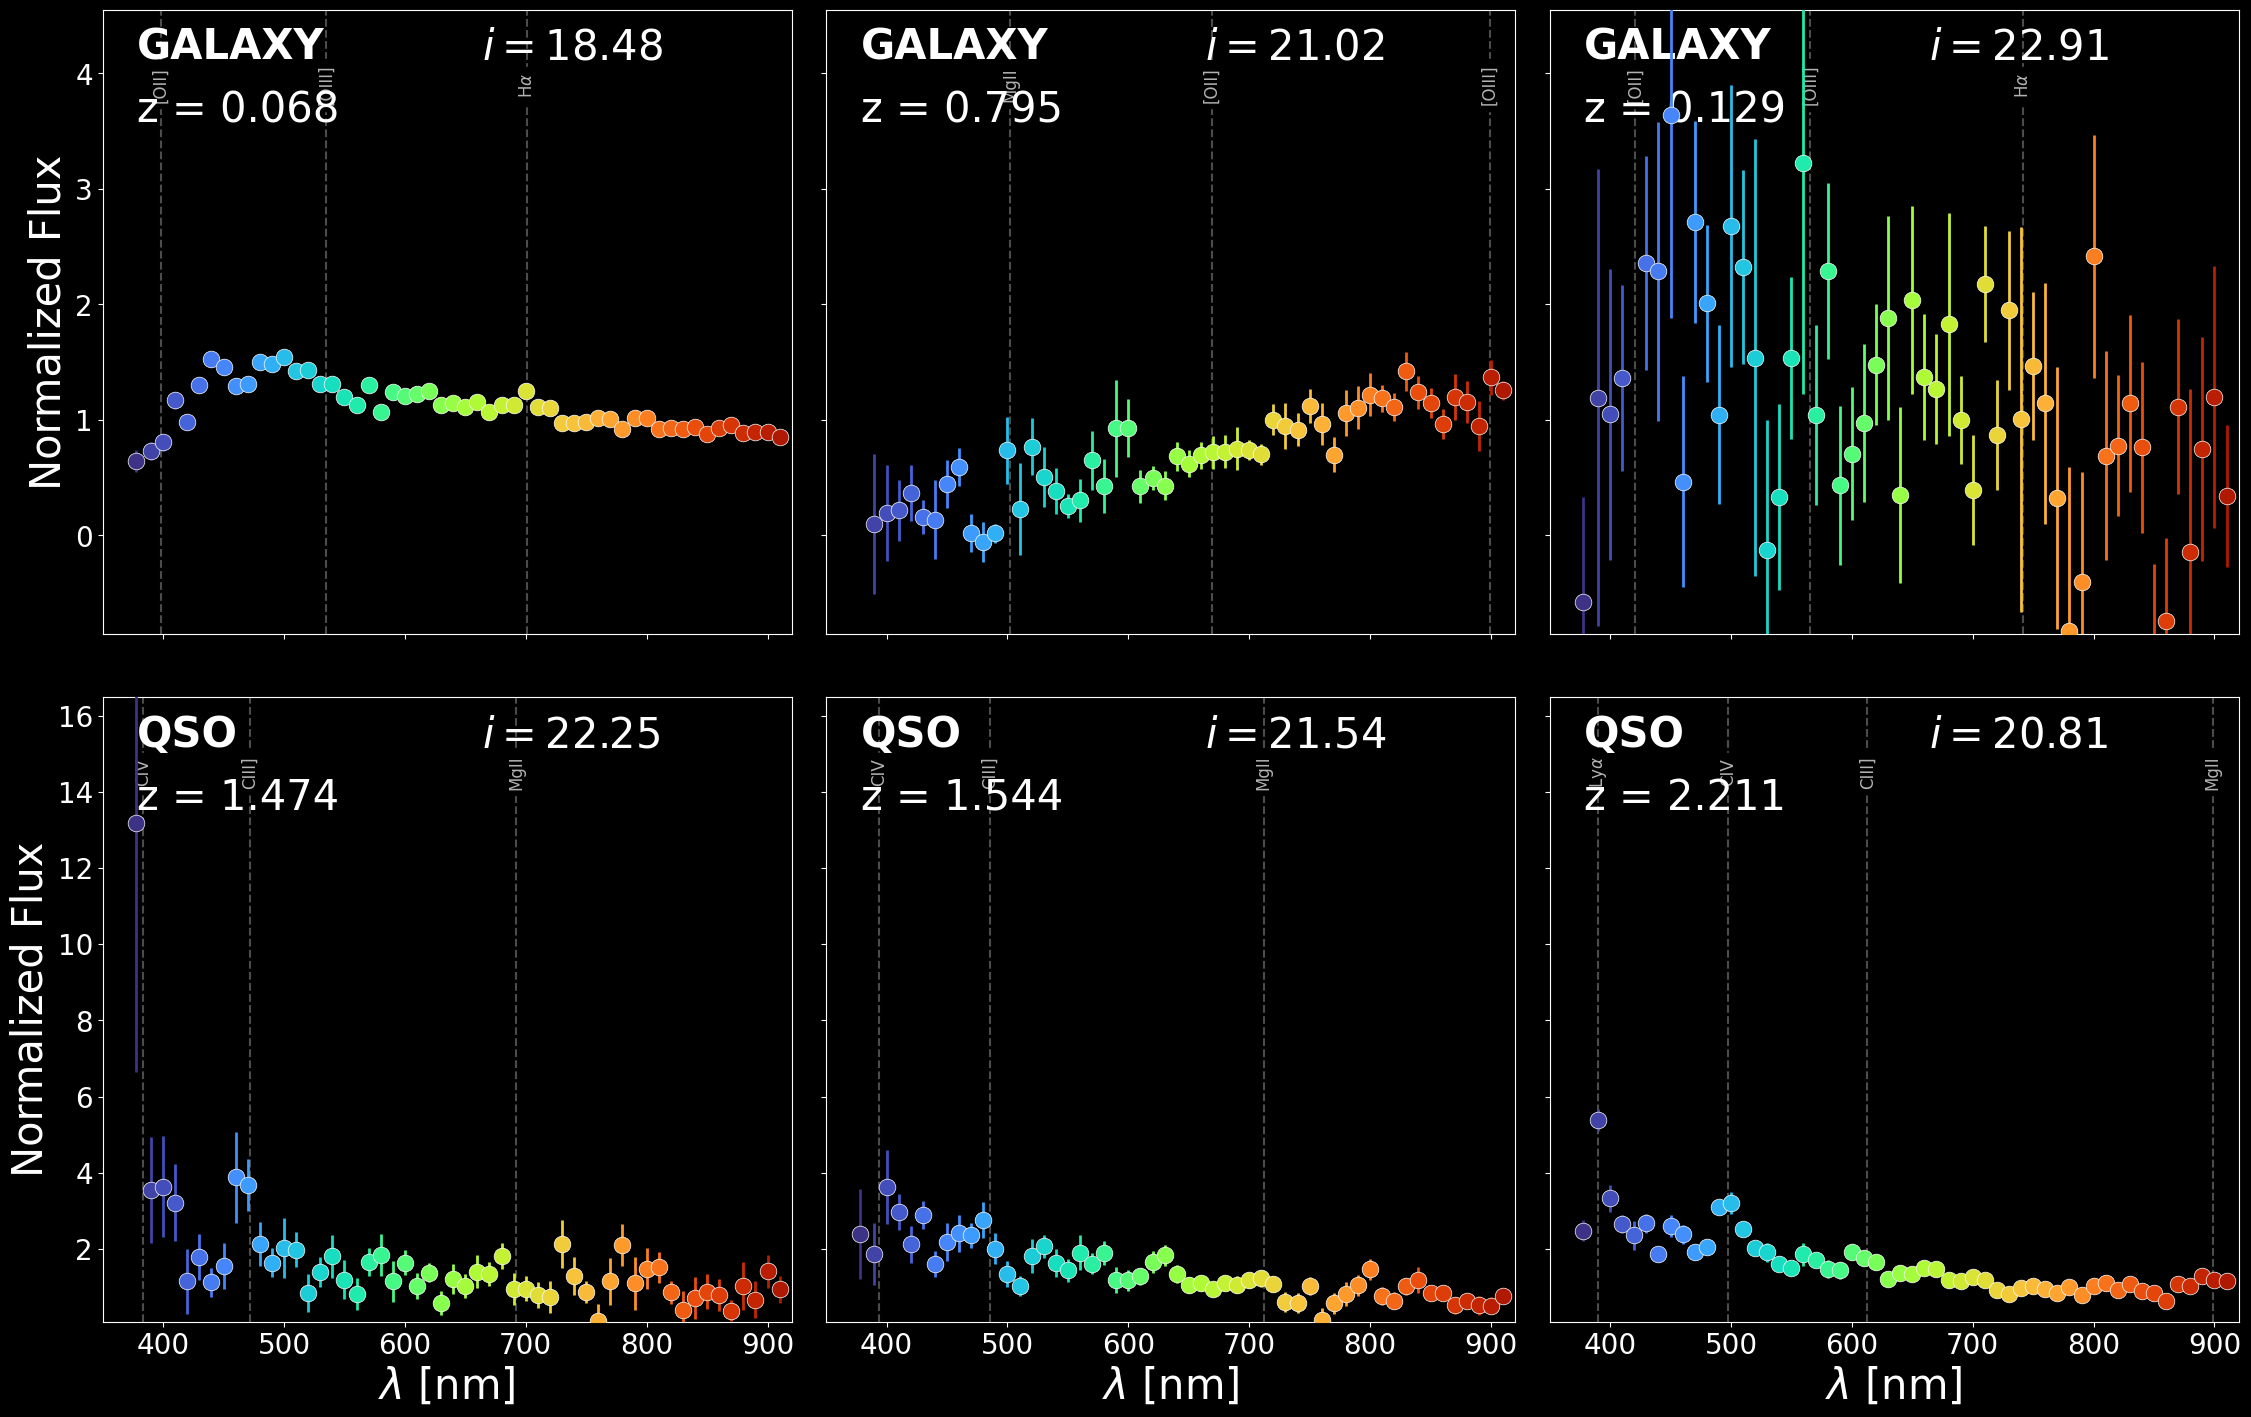

Plotting Broad-band Magnitude SED... 🌌


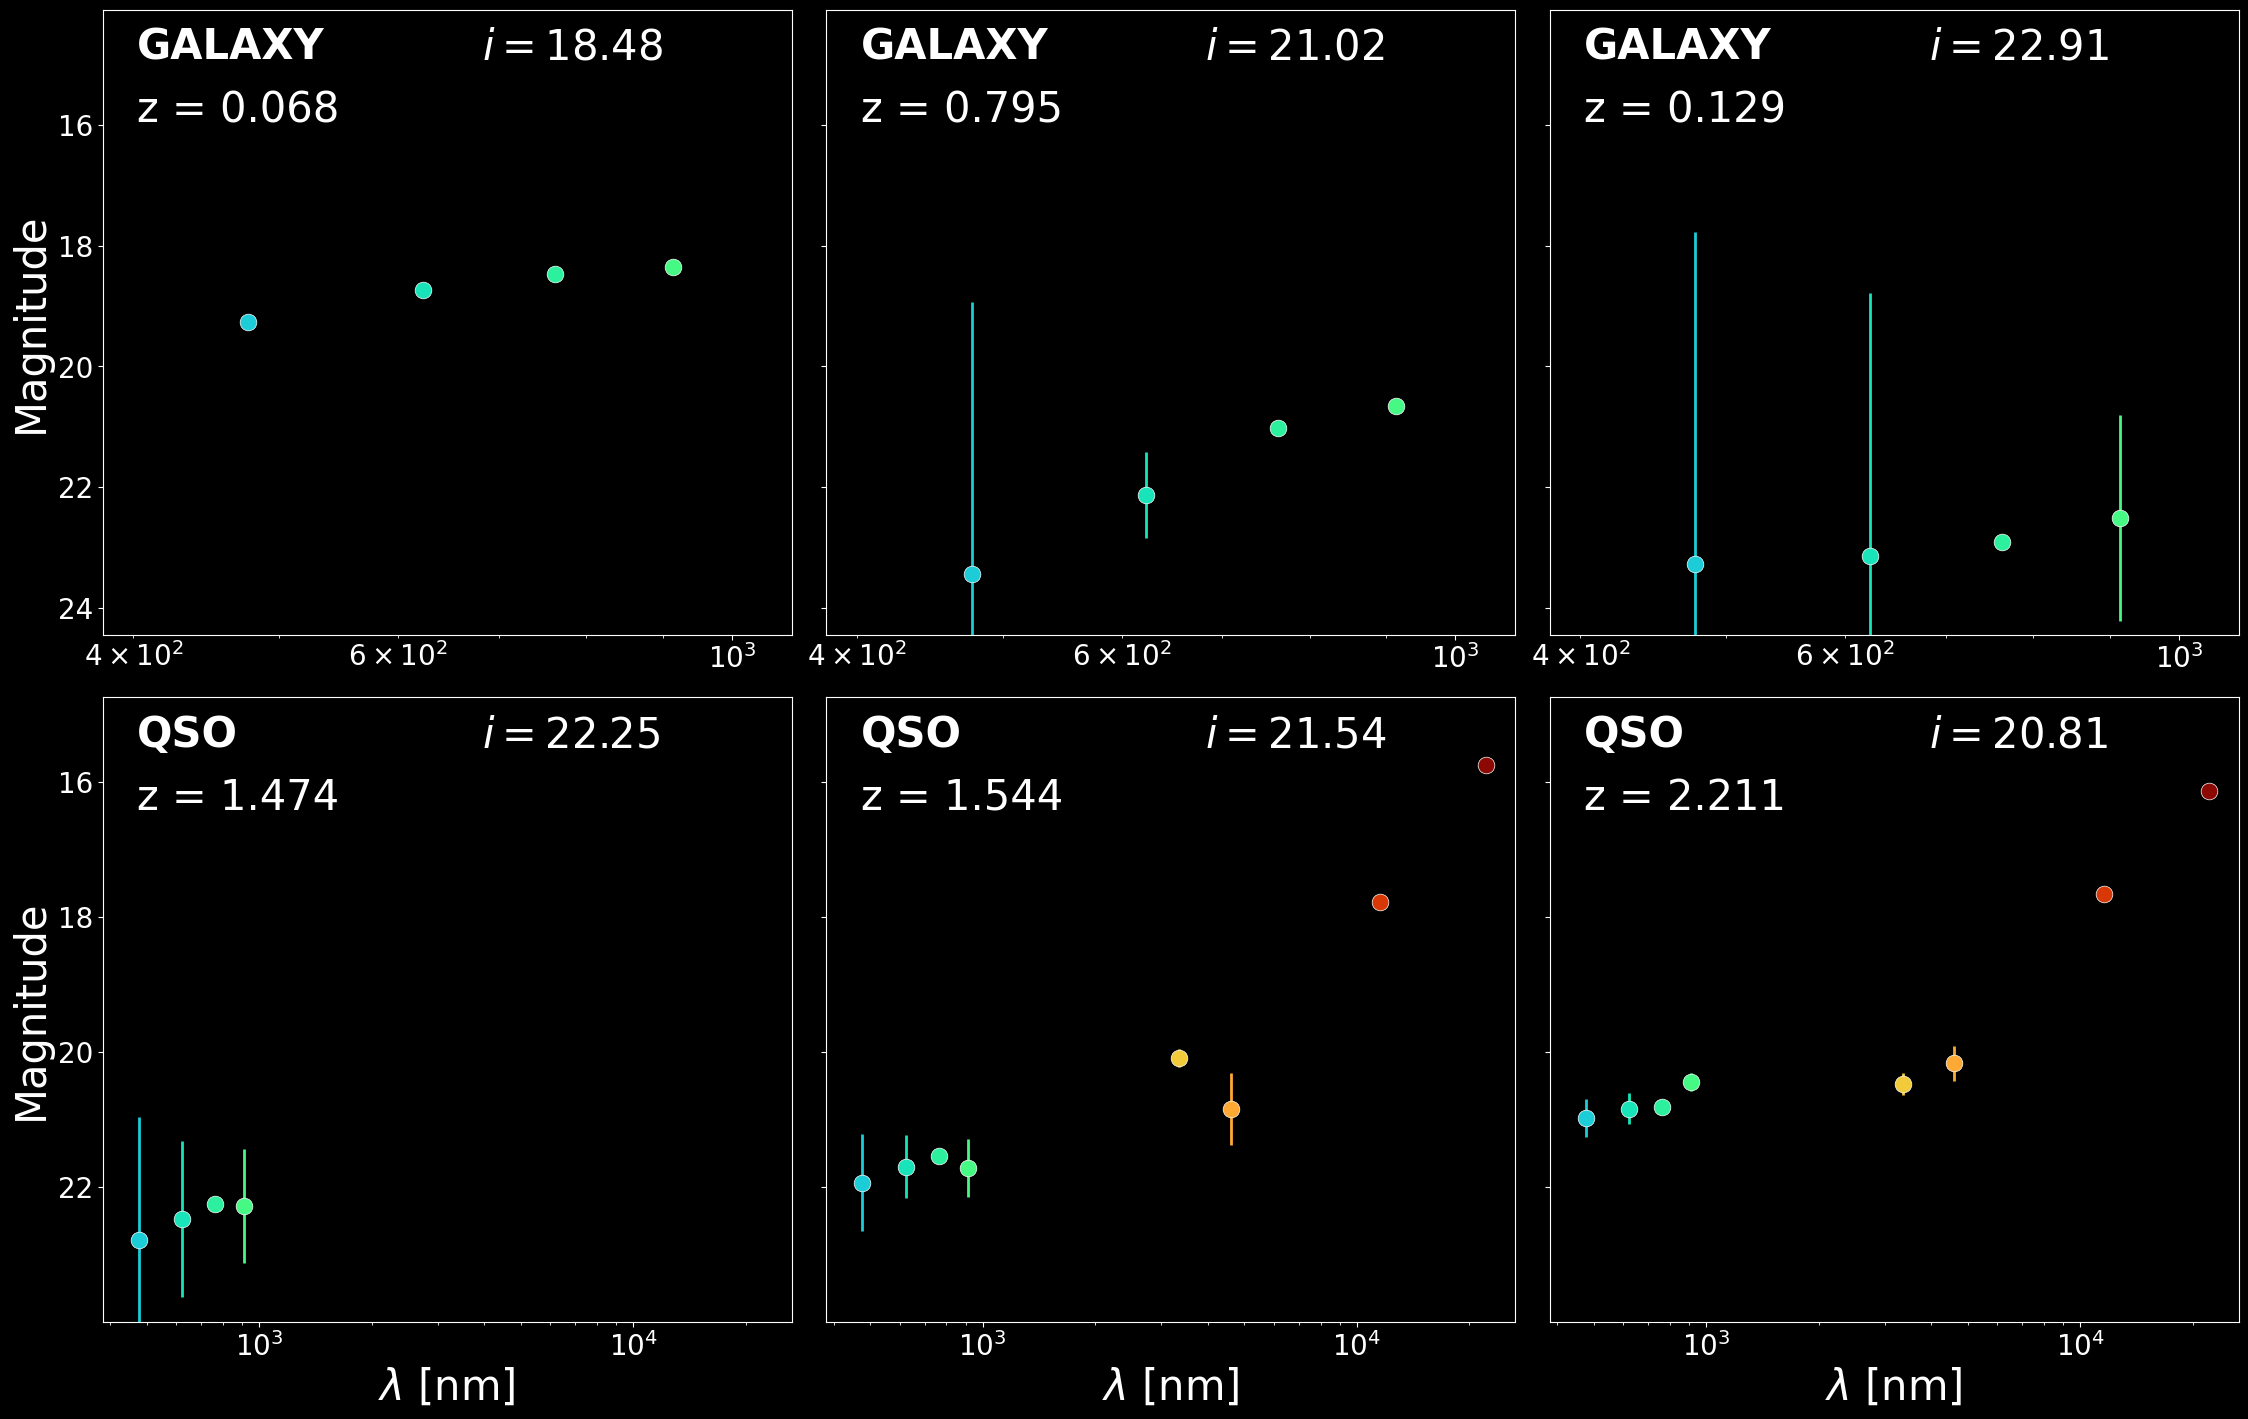

All SED plots displayed successfully! 🚀


In [18]:

JPAS_BANDS = [
    'J0378','J0390','J0400','J0410','J0420','J0430','J0440','J0450',
    'J0460','J0470','J0480','J0490','J0500','J0510','J0520','J0530',
    'J0540','J0550','J0560','J0570','J0580','J0590','J0600','J0610',
    'J0620','J0630','J0640','J0650','J0660','J0670','J0680','J0690',
    'J0700','J0710','J0720','J0730','J0740','J0750','J0760','J0770',
    'J0780','J0790','J0800','J0810','J0820','J0830','J0840','J0850',
    'J0860','J0870','J0880','J0890','J0900','J0910'
]
EFF_WAVE_JPAS = {band: float(band[1:]) for band in JPAS_BANDS}

MAG_BANDS = [
    'MAG_NUV','MAG_FUV','MAG_G','MAG_R','MAG_i','MAG_Z',"MAG_J_2MASS",
    "MAG_H_2MASS","MAG_Ks_2MASS",'MAG_W1','MAG_W2','MAG_W3','MAG_W4'
]
EFF_WAVE_MAG = {
    'MAG_FUV': 151.6, 'MAG_NUV': 226.7, 'MAG_G': 477.0, 'MAG_R': 623.1, 
    'MAG_i': 762.5, 'MAG_Z': 913.4, 'MAG_J_2MASS': 1235.0, 'MAG_H_2MASS': 1662.0, 
    'MAG_Ks_2MASS': 2159.0, 'MAG_W1': 3352.0, 'MAG_W2': 4602.0, 'MAG_W3': 11560.0, 'MAG_W4': 22080.0
}

REF_EMISSION_LINES = {
    r'Ly$\alpha$': 121.567, r'CIV': 154.906, r'CIII]': 190.873,
    r'MgII': 279.875, r'[OII]': 372.709, r'[OIII]': 500.684, r'H$\alpha$': 656.280
}

def plot_panel_sed(ax, row, bands_list, wave_dict, is_mag=False, is_left=False, is_bottom=False, ylim=None):
    obj_type = row.get('TYPE', 'UNKNOWN')
    z = row.get('Z', 0.0)
    mag_i = row.get('MAG_i', np.nan)

    waves, vals, errs = [], [], []
    for b in bands_list:
        val = row.get(b, np.nan)
        if np.isfinite(val):
            vals.append(val)
            waves.append(wave_dict[b])
            err_col = f"{b}_ERR"
            errs.append(row.get(err_col, 0.0))

    waves, vals, errs = np.array(waves), np.array(vals), np.array(errs)
    
    norm = mcolors.LogNorm(vmin=100, vmax=25000) if is_mag else mcolors.Normalize(vmin=350, vmax=950)
    cmap = plt.get_cmap('turbo')
    colors = cmap(norm(waves))

    for i in range(len(waves)):
        ax.errorbar(waves[i], vals[i], yerr=errs[i], fmt='o', ecolor=colors[i], 
                    markerfacecolor=colors[i], markeredgecolor='white', markeredgewidth=0.5,
                    markersize=12, elinewidth=2, zorder=10)

    if not is_mag and obj_type in ['GALAXY', 'QSO']:
        ymin_p, ymax_p = ylim if ylim else (np.min(vals), np.max(vals))
        for name, l_rest in REF_EMISSION_LINES.items():
            l_obs = l_rest * (1 + z)
            if 350 < l_obs < 920:
                ax.axvline(x=l_obs, color='gray', linestyle='--', linewidth=1.5, alpha=0.6, zorder=1)
                y_text = ymin_p + 0.88 * (ymax_p - ymin_p)
                ax.text(l_obs, y_text, name, rotation=90, color='white', fontsize=12,
                        va='center', ha='center', backgroundcolor='black', alpha=0.7)

    ax.text(0.05, 0.92, f"{obj_type}", 
            transform=ax.transAxes, color='white', 
            fontweight='bold', fontsize=30)
    ax.text(0.05, 0.82, f"z = {z:.3f}",
            transform=ax.transAxes, color='white', 
            fontsize=30)
    ax.text(0.55, 0.92, f"$i = {mag_i:.2f}$", 
            transform=ax.transAxes, color='white',
            fontsize=30)

    if is_bottom: ax.set_xlabel(r'$\lambda$ [nm]',fontsize=30)
    if is_left: ax.set_ylabel('Magnitude'
                              if is_mag else 
                              'Normalized Flux',fontsize=30)
    
    if is_mag:
        ax.set_xscale('log')
        ax.invert_yaxis()
    
    if not is_left: ax.tick_params(labelleft=False)
    
    if not is_mag:
        ax.set_xlim(350, 920)
    else:
        ax.set_xlim(np.min(waves)*0.8, np.max(waves)*1.2)
        
    if ylim: ax.set_ylim(ylim)

# Load config and execute
with open("config.yaml", 'r') as f:
    cfg = yaml.safe_load(f)

df_val = pd.read_hdf(cfg['data']['train_path'], key='data')
if 'Z' not in df_val.columns:
    df_val['Z'] = np.where(df_val['SPECTYPE'] == 2.0, df_val.get('Z_QSO', 0), df_val.get('Z_GAL', 0))

# Sample 3 Galaxies and 3 QSOs
sample_gal = df_val[df_val['TYPE'] == 'GALAXY'].sample(3)
sample_qso = df_val[df_val['TYPE'] == 'QSO'].sample(3)
plot_df = pd.concat([sample_gal, sample_qso]) 

# --- PLOT 1: J-PAS SED ---
print("Plotting J-PAS Photo-spectra... 🌠")
fig, axes = plt.subplots(2, 3, figsize=(24, 16), sharex=True)
plt.subplots_adjust(wspace=0.05, hspace=0.1, left=0.08, right=0.97, bottom=0.1, top=0.92)

for i, (idx, row) in enumerate(plot_df.iterrows()):
    ax = axes[i // 3, i % 3]
    row_data = plot_df.iloc[(i//3)*3 : (i//3)*3 + 3][JPAS_BANDS].values.flatten()
    row_data = row_data[np.isfinite(row_data)]
    ylim = (np.min(row_data)*0.9, np.max(row_data)*1.25) if len(row_data)>0 else None
    
    plot_panel_sed(ax, row, JPAS_BANDS, EFF_WAVE_JPAS, is_mag=False, 
                   is_left=(i%3==0), is_bottom=(i//3==1), ylim=ylim)
plt.show() # <--- Display inline!

# --- PLOT 2: Broadband SED ---
print("Plotting Broad-band Magnitude SED... 🌌")
fig, axes = plt.subplots(2, 3, figsize=(24, 16), sharex='row')
plt.subplots_adjust(wspace=0.05, hspace=0.1, left=0.08, right=0.97, bottom=0.1, top=0.92)

for i, (idx, row) in enumerate(plot_df.iterrows()):
    ax = axes[i // 3, i % 3]
    row_data = plot_df.iloc[(i//3)*3 : (i//3)*3 + 3][MAG_BANDS].values.flatten()
    row_data = row_data[np.isfinite(row_data)]
    ylim = (np.max(row_data)+1, np.min(row_data)-1) if len(row_data)>0 else None
    
    plot_panel_sed(ax, row, MAG_BANDS, EFF_WAVE_MAG, is_mag=True, 
                   is_left=(i%3==0), is_bottom=(i//3==1), ylim=ylim)
plt.show() # <--- Display inline!

print("All SED plots displayed successfully! 🚀")